In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

import os
import sys
from pathlib import Path
from pprint import pprint
import pickle
from scipy.optimize import curve_fit

from utils import analysis, utils, files # sibling package...

In [3]:
experiment = "emg_olympics"
subject = "jesse"
path_dictionary = files.build_experiment_path_dict(experiment)
subject_metadata_folder = utils.get_subject_folder(experiment,subject)

data folder:  /mnt/c/Users/spencer/data/emg_olympics


bars
- variance compared to movements
- explained by movements?
- height of target bar vs height of other bars? (some type of score)
- "shape" of bar data overall? 
  - dimensionality
  - ...?
- search strategy (dynamical modes?)

targets
- dimensionality
- search strategy
- comparison to natural movements (what movements are you making per target?)

In [4]:
def get_session_path_list(experiment, subject):
    path_dictionary = files.build_experiment_path_dict(experiment)
    session_dict = path_dictionary["subjects"][subject]["tasks"]["center_hold"]["sessions"]
    session_path_list = []

    for session in sorted(list(session_dict.keys()),key=lambda x: int(x.split("_")[-1])):
        session_path_list.append(session_dict[session])
    return session_path_list

def get_outcomes(experiment, subject):
    session_path_list = get_session_path_list(experiment, subject)
    num_sessions = len(session_path_list)
    hits = []
    misses = []
    noholds = []
    reach_times = []
    for behavior_path in session_path_list:
        outcome_path = [x for x in behavior_path.iterdir() if "result" in x.name][0]
        behavior = np.genfromtxt(str(outcome_path), delimiter=',', skip_header=1, dtype=None, encoding=None)
        outcomes = [x[0] for x in behavior]
        for x in behavior:
            if x[0] == "Hit":
                reach_times.append(x[2])
        uniques, counts = np.unique(outcomes, return_counts=True)
        for outcome, count in zip(uniques, counts):
            if outcome == "Hit":
                hits.append(count)
            elif outcome == "Miss":
                misses.append(count)
            elif outcome == "No Hold":
                noholds.append(count)
            else:
                raise ValueError("Unforeseen outcome in behavior: ", outcome)
        if "Hit" not in outcomes:
            hits.append(0)
        if "Miss" not in outcomes:
            misses.append(0)
        if "No Hold" not in outcomes:
            noholds.append(0)
    return hits, misses, noholds, num_sessions

def get_subjects(experiment, removed=None):
    folder = utils.get_experiment_data_folder(experiment)
    if removed is None:
        return [f.name for f in folder.iterdir()]
    else:
        return [f.name for f in folder.iterdir() if f.name not in removed]

def log(x, a, b):
    return b * np.log(x) + a

In [5]:
experiment = "emg_olympics"
subjects = get_subjects(experiment, removed=["andy","matthias","peter"])

aliases = {
    "jesse":"Placid Owner",
    "lars":"Luxury Boot",
    "bob":"Beaded Microchip",
    "peter":"Petty Driver" ,
    "miranda":"Reflective Director",
    "dammy":"Breezy Door",
    "oriol":"Crouching Turtle",
    "nate":"Hungry Tree",
    "april": "Decisive Apple",
    "zane":"Jubilant Butterfly",
    "georgia":"Pouncing Daffodil",
    "holly":"Reparable Semiconductor", 
    "alba":"Gregarious Stone",
    "hyewon":"Pensive Fountain"
}

print(f"num subjects: {len(subjects)}:")
for subject in subjects:
    if subject not in list(aliases.keys()):
        print(f"NO ALIAS: ", subject)
    else:
        print(subject, "AKA", aliases[subject])


data folder:  /mnt/c/Users/spencer/data/emg_olympics
num subjects: 12:
alba AKA Gregarious Stone
april AKA Decisive Apple
bob AKA Beaded Microchip
dammy AKA Breezy Door
georgia AKA Pouncing Daffodil
holly AKA Reparable Semiconductor
jesse AKA Placid Owner
lars AKA Luxury Boot
miranda AKA Reflective Director
nate AKA Hungry Tree
oriol AKA Crouching Turtle
zane AKA Jubilant Butterfly


data folder:  /mnt/c/Users/spencer/data/emg_olympics
data folder:  /mnt/c/Users/spencer/data/emg_olympics
data folder:  /mnt/c/Users/spencer/data/emg_olympics


/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a


data folder:  /mnt/c/Users/spencer/data/emg_olympics
data folder:  /mnt/c/Users/spencer/data/emg_olympics
data folder:  /mnt/c/Users/spencer/data/emg_olympics
data folder:  /mnt/c/Users/spencer/data/emg_olympics


/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a


data folder:  /mnt/c/Users/spencer/data/emg_olympics
data folder:  /mnt/c/Users/spencer/data/emg_olympics
data folder:  /mnt/c/Users/spencer/data/emg_olympics
data folder:  /mnt/c/Users/spencer/data/emg_olympics


/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a
/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a


data folder:  /mnt/c/Users/spencer/data/emg_olympics


/tmp/ipykernel_783/2440466779.py:50: RuntimeWarning: divide by zero encountered in log
  return b * np.log(x) + a


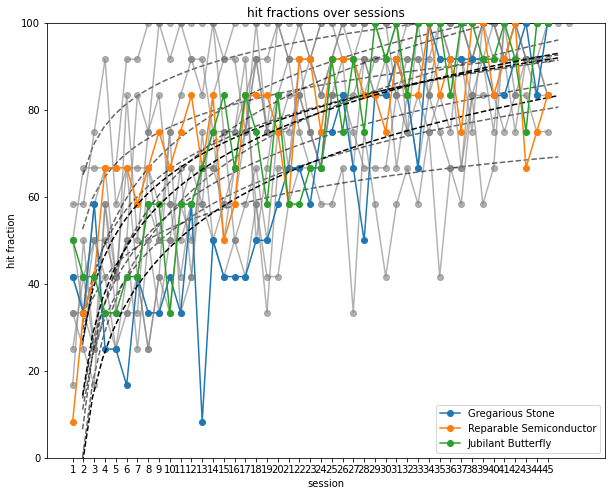

In [8]:
stats = []
hf=[]
fig, ax = plt.subplots(1,1,figsize=(10,8))
subjects_to_plot = ["holly","zane","alba"]
for subject in subjects:
    hits, misses, noholds, num_sessions = get_outcomes(experiment, subject)
    fractions = [h*(100/12) for h in hits]
    sessions_idxs = range(len(fractions))
    x = np.linspace(0,num_sessions,50)
    popt, pcov = curve_fit(log, list(range(1, num_sessions+1)), fractions)
    total_fraction = 100*sum(hits)/(num_sessions*12)
    stats.append(f"{aliases[subject]}: \n Hit Fraction: {round(total_fraction,1)}% \n Baseline: {round(popt[0],1)}% \n Rate: {round(popt[1],1)} \n")
    hf.append(total_fraction)
    if subject in subjects_to_plot:
        ax.plot(fractions , "-o", label=aliases[subject],zorder=10)
        plt.plot(x, log(x, *popt), 'k--',zorder=10)
    else:
        ax.plot(fractions , "-o", color="gray", alpha=0.6)
        plt.plot(x, log(x, *popt), 'k--', alpha=0.6)
ax.set_xlabel("session")
ax.set_ylabel("hit fraction")
ax.set_title("hit fractions over sessions")
ax.set_ylim([0,100])
ax.set_xticks(range(num_sessions))
ax.set_xticklabels(range(1,num_sessions+1))
ax.legend()

In [7]:
for i in np.argsort(hf)[::-1]:
    print(stats[i])

Pouncing Daffodil: 
 Hit Fraction: 94.3% 
 Baseline: 65.5% 
 Rate: 9.9 

Placid Owner: 
 Hit Fraction: 85.0% 
 Baseline: 27.7% 
 Rate: 20.0 

Luxury Boot: 
 Hit Fraction: 83.0% 
 Baseline: 53.4% 
 Rate: 10.3 

Crouching Turtle: 
 Hit Fraction: 80.2% 
 Baseline: 8.7% 
 Rate: 24.9 

Hungry Tree: 
 Hit Fraction: 76.9% 
 Baseline: 32.2% 
 Rate: 15.6 

Reparable Semiconductor: 
 Hit Fraction: 76.3% 
 Baseline: 28.4% 
 Rate: 16.7 

Jubilant Butterfly: 
 Hit Fraction: 74.1% 
 Baseline: 16.1% 
 Rate: 20.2 

Beaded Microchip: 
 Hit Fraction: 73.0% 
 Baseline: 2.2% 
 Rate: 24.7 

Reflective Director: 
 Hit Fraction: 68.7% 
 Baseline: 15.2% 
 Rate: 18.6 

Breezy Door: 
 Hit Fraction: 63.9% 
 Baseline: 12.6% 
 Rate: 17.9 

Gregarious Stone: 
 Hit Fraction: 63.0% 
 Baseline: 0.8% 
 Rate: 21.7 

Decisive Apple: 
 Hit Fraction: 59.6% 
 Baseline: 30.3% 
 Rate: 10.2 



## reach variance

## load data

In [5]:
experiment = "emg_olympics"
subject = "bob"

movement_session = "1"
calibration_session = "0"
center_hold_session = "0" # check manually for a folder, default to the first one

subject_metadata_folder = utils.get_subject_folder(experiment=experiment, subject=subject)
assert subject_metadata_folder.exists()
print("subject metadata: ", subject_metadata_folder)

subject metadata:  /mnt/c/Users/spencer/Documents/kyberphysics/metadata/emg_olympics/bob


In [7]:
ed = files.build_experiment_path_dict(experiment)
print(ed["subjects"].keys())
if not center_hold_session is None:
    path = utils.get_session_path(ed, subject, "center_hold", "session_" + str(center_hold_session))
    print(path)
    chd = utils.load_center_hold_emg(path)
    print("center hold: ", chd.keys())

data folder:  /mnt/c/Users/spencer/data/emg_olympics
dict_keys(['andy', 'bob', 'dammy', 'matthias', 'miranda', 'peter'])
/mnt/c/Users/spencer/data/emg_olympics/bob/center_hold/session_0
center hold:  dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])


In [8]:
if not center_hold_session is None:
    path = utils.get_session_path(ed, subject, "center_hold", "session_" + str(center_hold_session))
    print(path)
    chd = utils.load_center_hold_emg(path)
    print("center hold: ", chd.keys())

/mnt/c/Users/spencer/data/emg_olympics/bob/center_hold/session_0
center hold:  dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])


In [12]:
if not center_hold_session is None:
    concat_center_hold_data = utils.concat_emg_trials(chd)[:,:64]
    concat_center_hold_data = analysis.highpass(concat_center_hold_data,cutoff=3)
    print(concat_center_hold_data.shape)
    center_hold_vars = np.std(concat_center_hold_data, axis=0)
    center_hold_means = np.mean(concat_center_hold_data, axis=0)

(122420, 64)


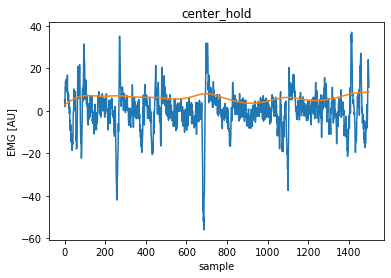

In [18]:
start=3000
stop = 4500
channel=11
low_cutoff=5
if not center_hold_session is None:
    plt.figure()
    hp = concat_center_hold_data[start:stop]
    lp = analysis.lowpass(analysis.rectify(hp), cutoff=low_cutoff)
    plt.plot(hp[:,channel])
    plt.plot(lp[:,channel])
    plt.title("center_hold")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")

(122420, 64)


No handles with labels found to put in legend.


-0.02411959868091181 4.209512924577172
min channel:  14
7.675474382647274e-05 4.209512924577172
(122420, 64)


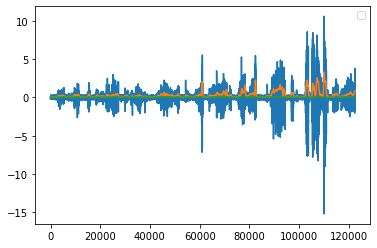

In [28]:
vars = np.diag(utils.load_array_from_disk(subject_metadata_folder / "variance.bin",dtype=np.float32).reshape(64,64)).reshape(64)**-1
end=-1
if not center_hold_session is None:
    standardized_center_hold_data = utils.standardize(concat_center_hold_data, vars)
    filtered_center_hold_data = utils.filter_emg(standardized_center_hold_data)
    # offset_center_hold_data = np.subtract(filtered_center_hold_data,offsets)
    plt.plot(standardized_center_hold_data[:end,channel])
    plt.plot(filtered_center_hold_data[:end,channel])
    # plt.plot(offset_center_hold_data[:end,channel],label="offset")
    if end == -1:
        plt.plot([0,filtered_center_hold_data.shape[0]],[0,0])
    else:
        plt.plot([0,end],[0,0])
    plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


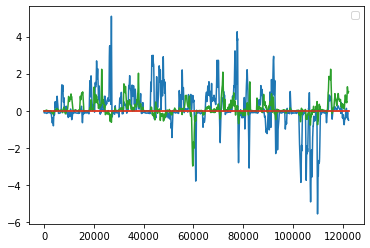

In [36]:
decoder = utils.load_array_from_disk(subject_metadata_folder / "decoder.bin").reshape(6,64)

# 2D preview
fig, ax = plt.subplots(1,1)
for c in decoder[-2:]:
    # baseline = np.dot(c,filtered_movement_data.T)
    baseline = np.dot(c,filtered_center_hold_data.T)
    ax.plot(baseline)
    ax.plot([0,baseline.shape[0]],[0,0])
    ax.legend()

# behavior

In [3]:
# behavior = []
# for session_path in get_session_path_list("bob"):
#     session_behavior = {}
#     trial_paths = [trial_path for trial_path in session_path.iterdir() if "behavior" in trial_path.name]
#     for trial in trial_paths:
#         session_no, target_ 
#         behavior_array = np.genfromtxt(str(trial), delimiter=',', skip_header=1, dtype=np.float, encoding=None)
        
#         session_behavior[] = behavior_array

#     behavior.append(session_behavior)

class Subject():
    def __init__(self):
        self.sessions = []

class Session():
    def __init__(self):
        self.trials = []
        self.number = None

class Trial():
    def __init__(self):
        self.session = 
        self.outcome
        self.time = 
        self.target = 
        self.behavior = self.get_behavior()
        self.signal = self.get_signal()

def get_session_paths(experiment, subject):
    pass

def get_session(session_number):
    pass

def get_trial_paths(session):

def get_trial_outcome(trial)

def build_behavior_dict(subject):
    session_path_list = get_session_path_list(subject)
    num_sessions = len(session_path_list)

    session_dict = {}


    hits = []
    misses = []
    noholds = []
    reach_times = []
    for behavior_path in session_path_list:
        print(behavior_path)
        outcome_path = [x for x in behavior_path.iterdir() if "result" in x.name][0]
        behavior = np.genfromtxt(str(outcome_path), delimiter=',', skip_header=1, dtype=None, encoding=None)
        outcomes = [x[0] for x in behavior]
        for x in behavior:
            if x[0] == "Hit":
                reach_times.append(x[2])
        uniques, counts = np.unique(outcomes, return_counts=True)
        for outcome, count in zip(uniques, counts):
            if outcome == "Hit":
                hits.append(count)
            elif outcome == "Miss":
                misses.append(count)
            elif outcome == "No Hold":
                noholds.append(count)
            else:
                raise ValueError("Unforeseen outcome in behavior: ", outcome)
        if "Hit" not in outcomes:
            hits.append(0)
        if "Miss" not in outcomes:
            misses.append(0)
        if "No Hold" not in outcomes:
            noholds.append(0)
    return hits, misses, noholds, num_sessions

build_behavior_dict("bob")

NameError: name 'path_dictionary' is not defined

# PCA

In [ ]:
# get components -- channel-wise covariance
num_components = 3
pca_model = PCA(n_components=num_components)
pca_model.fit(filtered_calibration_data)
pca_components = pca_model.components_
print(pca_components.shape)

In [ ]:
# screeplots
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,num_components+1), pca_model.explained_variance_ratio_)
ax1.set_ylabel("explained_variance")
ax1.set_xlabel("component")

ax2.plot(range(1,num_components+1), pca_model.singular_values_)
ax2.set_ylabel("singular value")
ax2.set_xlabel("component")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(pca_components[i].reshape(8,8),vmin=np.min(pca_components),vmax=np.max(pca_components))
    ax.set_title(str(i))

plt.figure()
plt.plot(pca_components[0]*np.sqrt(pca_model.singular_values_[0]))
plt.plot(movement_vars)

In [ ]:
print(np.dot(components[0],components[1]))
print(np.dot(components[1],components[1]))
print(np.linalg.norm(components[0]))

# factor analysis

https://stackoverflow.com/questions/37221635/rotation-argument-for-scikit-learns-factor-analysis
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA
https://scikit-learn.org/stable/auto_examples/decomposition/plot_varimax_fa.html#sphx-glr-auto-examples-decomposition-plot-varimax-fa-py
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
https://scikit-learn.org/stable/modules/decomposition.html#fa

In [ ]:
model = FactorAnalysis(n_components=num_components, random_state=0)
model.fit(standardized_data)
factors = model.components_
print(factors.shape)

In [ ]:
print(factors[0].shape)
print(np.dot(factors[0]/np.linalg.norm(factors[0]),
             factors[1]/np.linalg.norm(factors[1])))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,65), model.mean_)
ax1.set_ylabel("feature mean")
ax1.set_xlabel("feature")

ax2.plot(range(1,65), model.noise_variance_)
ax2.set_ylabel("feature noise variance")
ax2.set_xlabel("feature")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(factors[i].reshape(8,8))
    ax.set_title(str(i))